In [23]:
# Import
import pandas as pd
import darts
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Prophet
import matplotlib.pyplot as plt
from darts.utils.utils import SeasonalityMode
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, extract_trend_and_seasonality, ModelMode, remove_trend, remove_from_series, stationarity_tests
import glob 
import os
from darts.utils.missing_values import fill_missing_values
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import sys, os
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import STL
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from sklearn.metrics import f1_score, recall_score, precision_score

## Functions

In [3]:
def plot_outlier(predicted_df):
    fig, ax = plt.subplots(figsize=(18,6))
    outlier_points = predicted_df.loc[predicted_df['prediction'] == 1] #anomaly
    ax.plot(predicted_df.index, predicted_df['value'], color='blue', label = 'Normal')
    ax.scatter(outlier_points.index, outlier_points['value'], color='red', label = 'Anomaly')
    plt.legend()
    plt.show()
    # return ax

## Load & Preprocess Data

In [4]:
# Merging all files and making the dataframe
# df = pd.concat(map(pd.read_csv, glob.glob(os.path.join("./data" , "*.csv"))), ignore_index= True)
df = pd.read_csv('data/0.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.set_index('timestamp')
# df = df.asfreq(freq='T')
# df = df.interpolate()
df['label'] = df.label.astype(int)

In [5]:
df['lag_1'] = df['value'].shift(1)
df['lag_2'] = df['value'].shift(2)
df.fillna(0, inplace=True)

In [ ]:
# df_hourly = df.resample('H').mean()

In [6]:
# Create a TimeSeries, specifying the time and value columns
# Set aside the last 20 percent of ts as a validation series
# series = TimeSeries.from_dataframe(df_hourly, value_cols='value')
# train, val = series[:-round(len(df_hourly) / 5)], series[-round(len(df_hourly) / 5):]

In [7]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df['value'].values.reshape(-1, 1))
df['scaled'] = np_scaled
data = df[['scaled']]

## IsolationForest

In [8]:
outliers_fraction = float(.03)
if_model =  IsolationForest(contamination=outliers_fraction)
if_model.fit(data)

c:\users\legion\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01)

In [9]:
if_prediction_df = df.copy()
if_prediction_df['anomaly'] = if_model.predict(data)
if_prediction_df['prediction'] = np.where(if_prediction_df['anomaly']==-1, 1, 0)
if_prediction_df['prediction'].value_counts()

0    127277
1      1285
Name: prediction, dtype: int64

#### Visualization

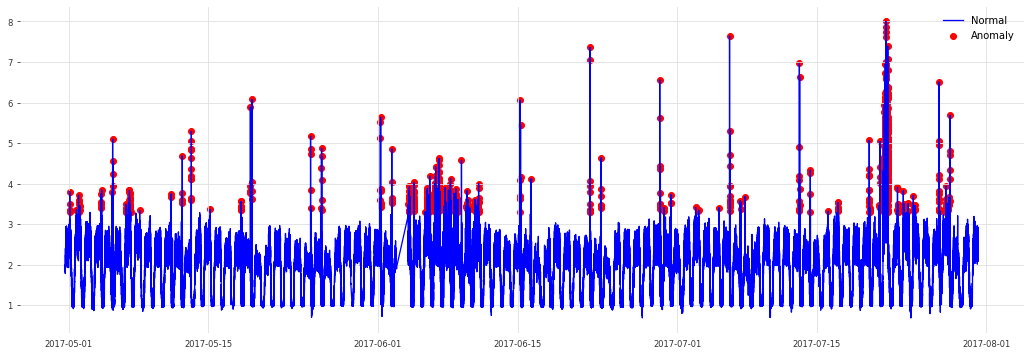

In [10]:
plot_outlier(if_prediction_df)

#### Metrics

In [12]:
f1_score(df['label'], if_prediction_df['prediction'])

KeyError: 'pred'

## KNN

In [13]:
outliers_fraction = float(0.03)
knn_model =  KNN(contamination=outliers_fraction)
knn_model.fit(data)

KNN(algorithm='auto', contamination=0.5, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [14]:
knn_prediction_df = df.copy()
knn_prediction_df['anomaly'] = knn_model.predict(data)
knn_prediction_df['prediction'] = np.where(knn_prediction_df['anomaly']==1, 1, 0)
knn_prediction_df['prediction'].value_counts()

0    127254
1      1308
Name: prediction, dtype: int64

#### Visualization

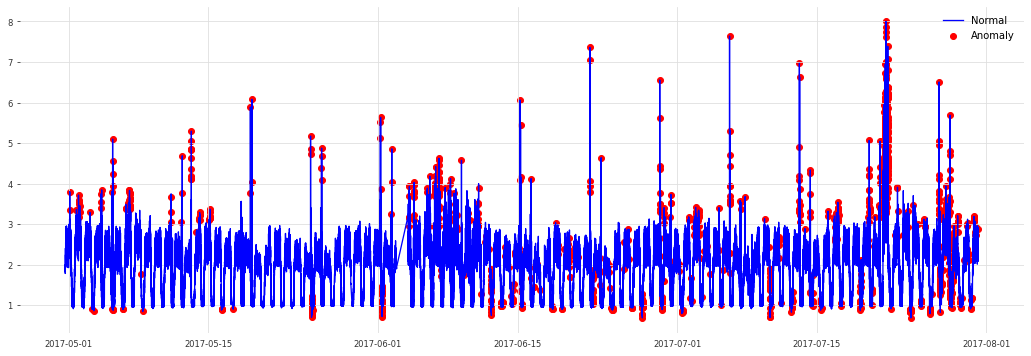

In [15]:
plot_outlier(knn_prediction_df)

#### Metrics

In [18]:
f1_score(df['label'], knn_prediction_df['prediction'])
# recall_score(df['label'], knn_prediction_df['prediction'])
# precision_score(df['label'], knn_prediction_df['prediction'])

0.09866756620003372

## DBSCAN

In [7]:
# dbscan_model = DBSCAN()
# dbscan_model.fit_predict(data)

: 

: 

## AutoregressionAD

In [21]:
from adtk.data import validate_series
s = validate_series(data)

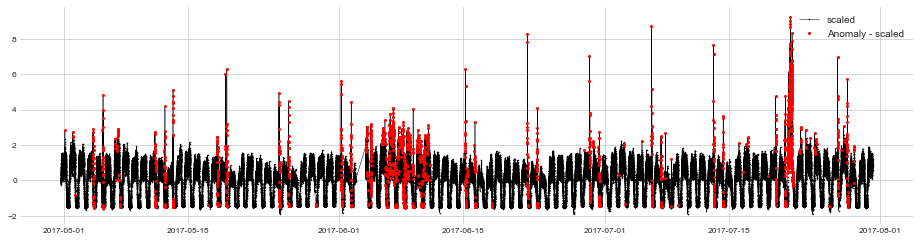

In [27]:
from adtk.detector import AutoregressionAD
autoregression_ad = AutoregressionAD(n_steps=7*2, step_size=24, c=3.0)
anomalies = autoregression_ad.fit_detect(s)

from adtk.visualization import plot
plot(s, anomaly=anomalies, ts_markersize=1, anomaly_color='red', anomaly_tag="marker", anomaly_markersize=2);

## QuantileAD

In [28]:
from adtk.detector import QuantileAD
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(s)

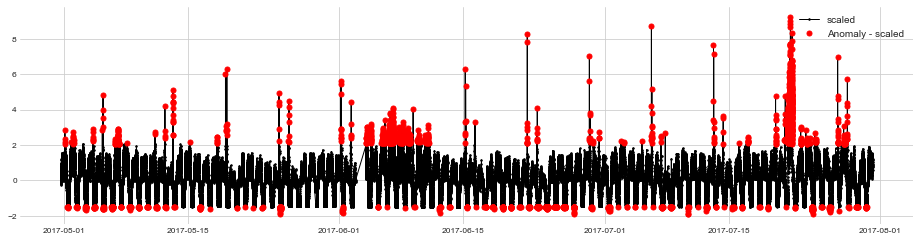

In [29]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

## InterQuartileRangeAD

In [30]:
from adtk.detector import InterQuartileRangeAD
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(s)

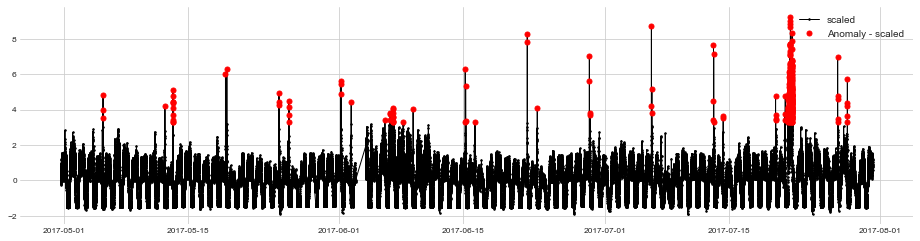

In [31]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

## GeneralizedESDTestAD

In [32]:
from adtk.detector import GeneralizedESDTestAD
esd_ad = GeneralizedESDTestAD(alpha=0.3)
anomalies = esd_ad.fit_detect(s)

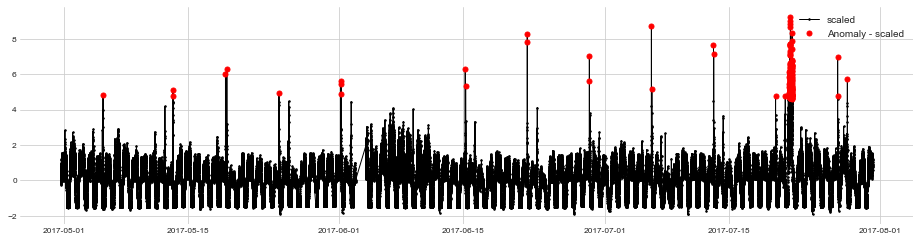

In [33]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

## PersistAD

In [34]:
s = validate_series(s)

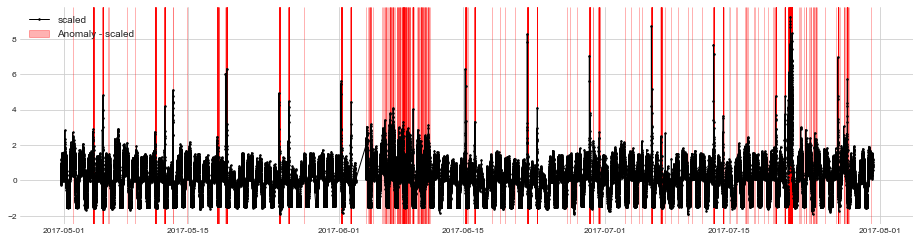

In [35]:
from adtk.detector import PersistAD
persist_ad = PersistAD(c=3.0, side='positive')
anomalies = persist_ad.fit_detect(s)
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red');

##### By default, PersistAD only check one previous value, which is good at capturing additive anomaly in short-term scale, but not in long-term scale because it is too near-sighted. In the following example, it fails to capture meaningful drops of price in a longer time scale.

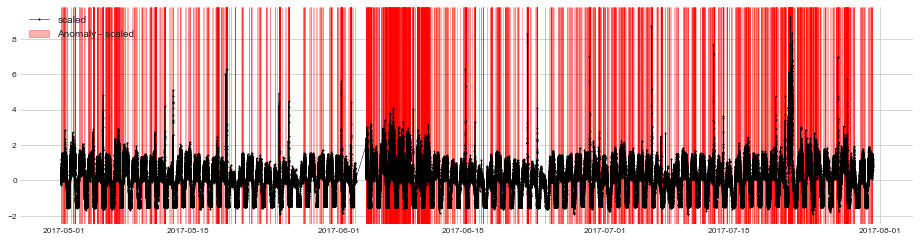

In [37]:
s = validate_series(s)
persist_ad = PersistAD(c=1.5, side='negative')
anomalies = persist_ad.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

## LevelShiftAD

In [38]:
s = validate_series(s)

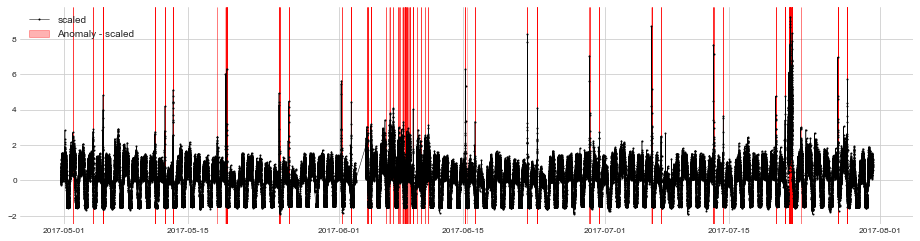

In [39]:
from adtk.detector import LevelShiftAD
level_shift_ad = LevelShiftAD(c=6.0, side='both', window=5)
anomalies = level_shift_ad.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

## VolatilityShiftAD

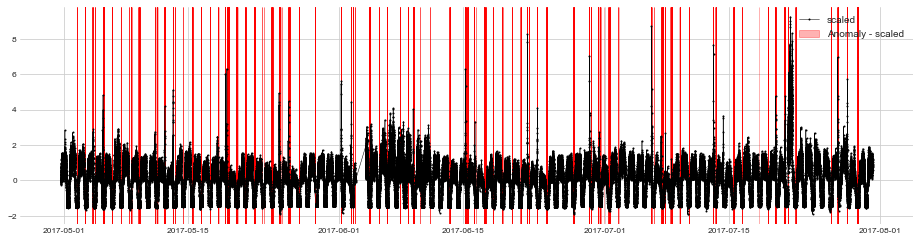

In [40]:
from adtk.detector import VolatilityShiftAD
volatility_shift_ad = VolatilityShiftAD(c=6.0, side='positive', window=30)
anomalies = volatility_shift_ad.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

## MinClusterDetector

c:\users\legion\appdata\local\programs\python\python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


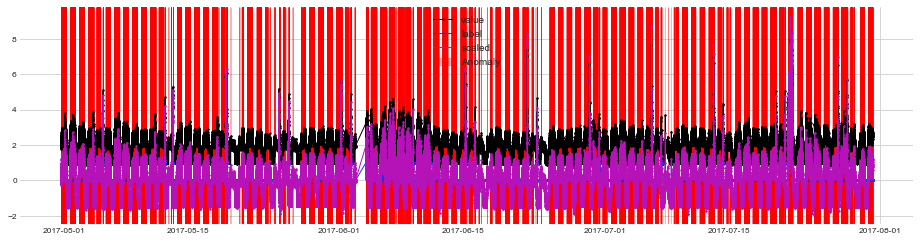

In [59]:
# This is more used in multivariate timeseries
from adtk.detector import MinClusterDetector
from sklearn.cluster import KMeans
min_cluster_detector = MinClusterDetector(KMeans(n_clusters=3))
anomalies = min_cluster_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

## PcaAD

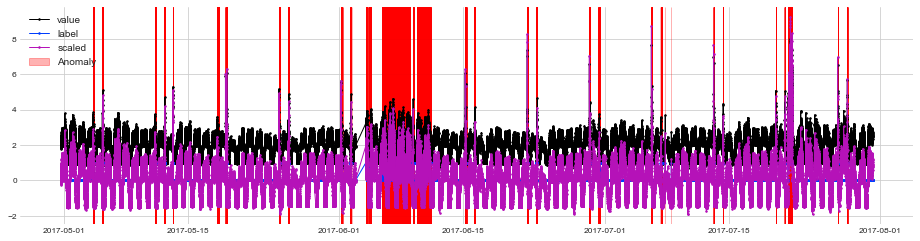

In [46]:
from adtk.detector import PcaAD
pca_ad = PcaAD(k=1)
anomalies = pca_ad.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

## Pipeline

In [49]:
from adtk.pipe import Pipeline
from adtk.transformer import ClassicSeasonalDecomposition
steps = [
    ("deseasonal", ClassicSeasonalDecomposition()),
    ("quantile_ad", QuantileAD(high=0.995, low=0.005))
]
pipeline = Pipeline(steps)

In [51]:
# s = validate_series(s)
# anomalies = pipeline.fit_detect(s)
# plot(s, anomaly=anomalies, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');

## Kats

In [56]:
from kats.detectors.outlier import OutlierDetector

ts_outlierDetection = OutlierDetector(air_passengers_outlier_ts, 'additive') # call OutlierDetector
ts_outlierDetection.detector() # apply OutlierDetector

In [57]:
ts_outlierDetection.outliers[0]

In [58]:
air_passengers_ts_outliers_removed = ts_outlierDetection.remover(interpolate = False) # No interpolation
air_passengers_ts_outliers_interpolated = ts_outlierDetection.remover(interpolate = True) # With interpolation

In [ ]:
fig, ax = plt.subplots(figsize=(20,8), nrows=1, ncols=2)
air_passengers_ts_outliers_removed.to_dataframe().plot(x = 'time',y = 'y_0', ax= ax[0])
ax[0].set_title("Outliers Removed : No interpolation")
air_passengers_ts_outliers_interpolated.to_dataframe().plot(x = 'time',y = 'y_0', ax= ax[1])
ax[1].set_title("Outliers Removed : With interpolation")
plt.show()

## pyfbad Anomaly detection

In [65]:
# import plotly.express as px
# from plotly.offline import iplot
# from pyfbad.data import database as db
# from pyfbad.models import models as md
# from pyfbad.features import create_feature as cf
# from pyfbad.notification import notifications as ntf